In [36]:
#install torch
%pip install torch==2.2.0 torchvision torchaudio


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


^C
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/pip/__main__.py", line 24, in <module>
    sys.exit(_main())
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 114, in _main
    options, args = self.parse_args(args)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 96, in parse_args
    return self.parser.parse_args(args)
  File "/opt/conda/lib/python3.10/optparse.py", line 1371, in parse_args
    values 

In [38]:
import json
import torch
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score
from tqdm import tqdm, trange

In [39]:
train = json.load(open('/kaggle/input/data-json/train_file.json'))
test = json.load(open('/kaggle/input/data-json/val_file.json'))

print('train:', len(train))
print('test:', len(test))

train: 6740
test: 843


## BERT ENCODINGS

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  


## DATALOADERS

# Convert json to csv

In [41]:
dialogue_ids = []
speaker = []
emotion = []
utterance = []
erf_label = []

for i in range(len(train)):
    dialogue_ids.append(train[i]['episode'])
    speaker.append(train[i]['speakers'])
    emotion.append(train[i]['emotions'])
    utterance.append(train[i]['utterances'])
    erf_label.append(train[i]['triggers'])
df_train = pd.DataFrame(list(zip(dialogue_ids, speaker, emotion, utterance, erf_label)), columns =['Dialogue_ID', 'Speaker', 'Emotion', 'Utterance', 'ERF_Label'])
# save this dataframe to a csv file
df_train.to_csv('train.csv', index=False)
dialogue_ids = []
speaker = []
emotion = []
utterance = []
erf_label = []

for i in range(len(test)):
    dialogue_ids.append(train[i]['episode'])
    speaker.append(train[i]['speakers'])
    emotion.append(train[i]['emotions'])
    utterance.append(train[i]['utterances'])
    erf_label.append(train[i]['triggers'])
df_test = pd.DataFrame(list(zip(dialogue_ids, speaker, emotion, utterance, erf_label)), columns =['Dialogue_ID', 'Speaker', 'Emotion', 'Utterance', 'ERF_Label'])
# save this dataframe to a csv file
df_test.to_csv('test.csv', index=False)


In [42]:
df_train.head()

,Dialogue_ID,Speaker,Emotion,Utterance,ERF_Label
0,utterance_3492,"[Phoebe, Eric, Phoebe, Eric, Phoebe]","[surprise, fear, surprise, sadness, disgust]","[You-you you had sex with Ursula?!, Uh, a litt...","[1.0, 1.0, 0.0, 0.0, 0.0]"
1,utterance_3952,"[Monica, Monica, Phoebe, Joey, Joey, Joey, Rac...","[disgust, disgust, anger, sadness, surprise, a...","[Dad, please don't pick your teeth out here!, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,utterance_3198,"[Older Scientist, Ross, Ross, Joey, Ross, Ross...","[neutral, neutral, neutral, neutral, neutral, ...","[Dr. Geller, there's a seat over here., Thank ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]"
3,utterance_2834,"[Monica, Monica, Monica]","[neutral, surprise, neutral]","[So, how'd the lasagne go over?, Really?!, Good.]","[0.0, 0.0, 1.0]"
4,utterance_453,"[Kate, The Director, Kate]","[joy, sadness, sadness]","[Become a drama critic!, I am hurt! A plague ...","[0.0, 0.0, 1.0]"


In [43]:
df_test.head()

,Dialogue_ID,Speaker,Emotion,Utterance,ERF_Label
0,utterance_3492,"[Phoebe, Eric, Phoebe, Eric, Phoebe]","[surprise, fear, surprise, sadness, disgust]","[You-you you had sex with Ursula?!, Uh, a litt...","[1.0, 1.0, 0.0, 0.0, 0.0]"
1,utterance_3952,"[Monica, Monica, Phoebe, Joey, Joey, Joey, Rac...","[disgust, disgust, anger, sadness, surprise, a...","[Dad, please don't pick your teeth out here!, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,utterance_3198,"[Older Scientist, Ross, Ross, Joey, Ross, Ross...","[neutral, neutral, neutral, neutral, neutral, ...","[Dr. Geller, there's a seat over here., Thank ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]"
3,utterance_2834,"[Monica, Monica, Monica]","[neutral, surprise, neutral]","[So, how'd the lasagne go over?, Really?!, Good.]","[0.0, 0.0, 1.0]"
4,utterance_453,"[Kate, The Director, Kate]","[joy, sadness, sadness]","[Become a drama critic!, I am hurt! A plague ...","[0.0, 0.0, 1.0]"


In [44]:
unicode_mapping = {}
unicode_mapping['\x85'] = '...' 
unicode_mapping['\x91'] = "'"
unicode_mapping['\x92'] = "'"
unicode_mapping['\x93'] = '"'
unicode_mapping['\x94'] = '"'
unicode_mapping['\x97'] = '--'

unicode_mapping['\u2014'] = '--'
unicode_mapping['\u2019'] = "'"
unicode_mapping['\u2026'] = '...'

unicode_mapping['\xe9'] = 'e'

def clean_utterance(utterance_list):
    '''	
    This function takes a list of utterances and replaces the unicode with the proper characters.
    '''
    cleaned_utterances_list = []
    for utterance in utterance_list:
        for key in unicode_mapping:
            utterance = utterance.replace(key, unicode_mapping[key])
        cleaned_utterances_list.append(utterance)
    return cleaned_utterances_list

train_uttr = df_train['Utterance'].apply(lambda x: clean_utterance(x))
df_train['Utterance'] = train_uttr
test_uttr = df_test['Utterance'].apply(lambda x: clean_utterance(x))
df_test['Utterance'] = test_uttr
for i in range(len(df_train)):
    for j in range(len(df_train['ERF_Label'][i])):
        if df_train['ERF_Label'][i][j] != 1.0 and df_train['ERF_Label'][i][j] != 0.0:
            df_train['ERF_Label'][i][j] = 0.0
    
    # for j in range(len(df_test['ERF_Label'][i])):
    #     if df_test['ERF_Label'][i][j] == 'None':
    #         df_test['ERF_Label'][i][j] = -1

for i in range(len(df_test)):
    for j in range(len(df_test['ERF_Label'][i])):
        if df_test['ERF_Label'][i][j] != 1.0 and df_test['ERF_Label'][i][j] != 0.0:
            df_test['ERF_Label'][i][j] = 0.0

In [45]:
print(df_train['Utterance'][0])

['You-you...you had sex with Ursula?!', 'Uh, a little bit. She-she-she walked in and I thought she was you and I kissed her and', "You didn't notice she was wearing different clothes?!", 'Well I was just so excited to see you.', "Oh. Ew! Ew! Ew! Ugh! Y'know what? This is too weird."]


In [46]:
# max length episode
max_len = 0
for i in range(len(df_train)):
    max_len = max(max_len, len(df_train['Utterance'][i]))
print(max_len)

24


In [47]:
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn


tokenizer = AutoTokenizer.from_pretrained("roberta-base")


In [48]:
class Model(nn.Module):
    #model consists of a EmoBERTa model and a linear layer for sequence labeling task
    def __init__(self, num_classes=2):
        super(Model, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids, attention_mask)
        out = outputs[0]
        out = out[:, 0, :]
        out = self.fc(out)
        # make sure output is either 0 or 1
        out = torch.sigmoid(out)
        out = torch.round(out)
        return out
class Dataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = self.process(data, tokenizer)
        self.max_len = max_len

    def __len__(self):
        return len(self.data['input'])

    def __getitem__(self, index):
        #tokenize the input
        input = self.data['input'][index]
        target = self.data['target'][index]
#         if target == 'None':
#             target = -1
#         print(target)
        encoding = self.tokenizer(input, return_tensors='pt', padding='max_length', max_length=self.max_len, truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'target':torch.tensor(target)}
        
    def process(self, data, tokenizer):
        new_data = {'input': [], 'target': []}
        for i in range(len(data)):
            newinput = data.loc[i].copy()
            stringlist = []
            for j in range(len(newinput['Utterance'])):
                stringlist.append(newinput['Speaker'][j] + ': ' + newinput['Utterance'][j] + ":" + newinput['Emotion'][j])
            for j in range(len(newinput['Utterance'])):
                #join till jth utterance
                temp = ' '.join(stringlist[:j])
                temp += '</s></s>'
                #add jth utterance
                temp += newinput['Speaker'][j] + ': ' + newinput['Utterance'][j] + ":" + newinput['Emotion'][j]
                temp += '</s></s>'
                #add later Utterence
                temp += ' '.join(stringlist[j+1:])
                temp = '<s> ' + temp + '</s>'
                new_data['input'].append(temp)
                target = newinput['ERF_Label'][j]
                # print(target)
                new_data['target'].append(target)
        return new_data
            
    

In [49]:
def collate_fn(batch):
    input_ids = []
    attention_mask = []
    target = []
    for b in batch:
        input_ids.append(b['input_ids'])
        attention_mask.append(b['attention_mask'])
        target.append(b['target'])
    input_ids = torch.stack(input_ids)
    attention_mask = torch.stack(attention_mask)
    target = torch.stack(target)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'target': target}

In [50]:
# take 10 samples only
# df_train = df_train[:100]
# df_test = df_test[:100]

train_Dataset = Dataset(df_train, tokenizer, 2)
train_loader = DataLoader(train_Dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

test_Dataset = Dataset(df_test, tokenizer, 2)
test_loader = DataLoader(test_Dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

model = Model(1)
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
print(len(train_loader), len(test_loader))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1843 229


In [51]:
# import wandb
# wandb.login(relogin=True)


In [52]:
# model_config = {
#     'model': 'RoBERTa Task 2',
#     'learning_rate': 1e-5,
#     'batch_size': 32,
#     'optimizer': 'AdamW',
#     'loss_function': 'BCE'
# }
# wandb.init(project='assignment-4', entity='nlp-assignments', config=model_config)


In [53]:
print(device)
def train(model,train_loader,test_loader,criterion,optimizer,num_class,epochs):
    train_losses = []
    test_losses = []
#     wandb.define_metric('epoch')
#     wandb.define_metric('train_epoch_loss', step_metric='epoch')
#     wandb.define_metric('val_epoch_loss', step_metric='epoch')
#     wandb.define_metric('f1_micro', step_metric='epoch')
#     wandb.define_metric('f1_macro', step_metric='epoch')
#     wandb.define_metric('f1_weighted', step_metric='epoch')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader):
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['target'].to(device)
            # print(input_ids)
#             print(input_ids.shape, attention_mask.shape, target.shape)
            optimizer.zero_grad()
            output = model(input_ids, attention_mask)
#             print(output[0], target)
            #make output
            # output = output.unsqueeze(0) 
#             print(output.shape, target.shape)
#             loss = criterion(output, target)
            loss = criterion(output.view(-1), target)
#             print(loss.item())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # break
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}')
        model.eval() 
        test_loss = 0
        
        with torch.no_grad():
            true_labels = []
            predictions = []
            for batch in tqdm(test_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                target = batch['target'].to(device)
                # print(input_ids)
                # print(input_ids.shape, attention_mask.shape, target.shape)
                optimizer.zero_grad()
                output = model(input_ids, attention_mask)
                # print(output, target)
                #make output
                # output = output.unsqueeze(0) 
                # print(output.shape, target.shape)
                # break 
#                 loss = criterion(output, target)
                loss = criterion(output.view(-1), target)
                predictions = torch.cat((output,), dim=0)
                true_labels = torch.cat((target,), dim=0)
                print(f1_score(target.detach().cpu().numpy(), output.detach().cpu().numpy(), average='micro'))
                test_loss += loss.item()
            
            f1_micro = f1_score(true_labels.detach().cpu().numpy(), predictions.detach().cpu().numpy(), average='micro')
            f1_macro = f1_score(true_labels.detach().cpu().numpy(), predictions.detach().cpu().numpy(), average='macro')
            f1_weighted = f1_score(true_labels.detach().cpu().numpy(), predictions.detach().cpu().numpy(), average='weighted')
            test_loss /= len(test_loader)
            test_losses.append(test_loss)
            print(f'Epoch {epoch+1}/{epochs}, Test Loss: {test_loss},F1 micro:{f1_micro}, F1 macro:{f1_macro},F1 weighted:{f1_weighted}')
#         log_dict = {
#         'epoch': epoch,
#         'train_epoch_loss': train_loss,
#         'val_epoch_loss': test_loss,
#         'f1_micro': f1_micro,
#         'f1_macro': f1_macro,
#         'f1_weighted': f1_weighted
#         }
#         wandb.log(log_dict)
    return train_losses,test_losses
            

cuda


In [54]:
train_losses,test_losses = train(model,train_loader,test_loader,criterion,optimizer,1,3)
torch.save(model, "model_m1_task_2.pth")

100%|██████████| 1843/1843 [02:05<00:00, 14.67it/s]


Epoch 1/3, Train Loss: 15.851167619842844


  2%|▏         | 4/229 [00:00<00:07, 30.30it/s]

0.84375
0.84375
0.875
0.8125
0.875
0.8125
0.875


  5%|▌         | 12/229 [00:00<00:07, 30.56it/s]

0.84375
0.71875
0.84375
0.875
0.875
0.84375
0.75


  9%|▊         | 20/229 [00:00<00:06, 30.70it/s]

0.9375
0.78125
0.75
0.78125
0.75
0.71875
0.90625


 10%|█         | 24/229 [00:00<00:06, 30.66it/s]

0.8125
0.875
0.90625
0.875
0.8125
0.875


 12%|█▏        | 28/229 [00:00<00:06, 30.85it/s]

0.78125


 14%|█▍        | 32/229 [00:01<00:06, 31.08it/s]

0.84375
0.75
0.9375
0.8125
0.84375
0.875
0.875


 17%|█▋        | 40/229 [00:01<00:05, 31.57it/s]

0.78125
0.90625
0.8125
0.71875
0.75
0.8125
0.875


 21%|██        | 48/229 [00:01<00:05, 31.16it/s]

0.875
0.90625
0.875
0.90625
0.8125
0.78125
0.90625


 23%|██▎       | 52/229 [00:01<00:05, 31.00it/s]

0.90625
0.8125
0.84375
0.90625
0.875
0.78125


 24%|██▍       | 56/229 [00:01<00:05, 31.17it/s]

0.875


 26%|██▌       | 60/229 [00:01<00:05, 31.06it/s]

0.90625
0.90625
0.875
0.78125
0.84375
0.75
0.90625


 30%|██▉       | 68/229 [00:02<00:05, 31.22it/s]

0.875
0.78125
0.84375
0.71875
0.84375
0.75
0.78125


 31%|███▏      | 72/229 [00:02<00:05, 30.55it/s]

0.875
0.875
0.8125
0.75
0.96875


 33%|███▎      | 76/229 [00:02<00:05, 30.22it/s]

0.84375


 35%|███▍      | 80/229 [00:02<00:05, 29.71it/s]

0.90625
0.90625
0.84375
0.875
0.9375
0.96875


 38%|███▊      | 87/229 [00:02<00:04, 30.48it/s]

0.75
0.8125
0.875
0.8125
0.84375
0.96875
0.84375


 41%|████▏     | 95/229 [00:03<00:04, 30.74it/s]

0.875
0.9375
0.875
0.8125
0.84375
0.90625
0.8125


 43%|████▎     | 99/229 [00:03<00:04, 30.99it/s]

0.8125
0.6875
0.78125
0.9375
0.875
0.8125


 45%|████▍     | 103/229 [00:03<00:04, 30.52it/s]

0.875


 47%|████▋     | 107/229 [00:03<00:03, 30.87it/s]

0.75
0.84375
0.78125
0.90625
0.9375
0.875
0.84375


 50%|█████     | 115/229 [00:03<00:03, 31.02it/s]

0.875
0.8125
0.90625
0.75
0.6875
0.875
0.78125


 54%|█████▎    | 123/229 [00:03<00:03, 31.23it/s]

0.9375
0.9375
0.9375
0.90625
0.84375
0.8125
0.75


 55%|█████▌    | 127/229 [00:04<00:03, 31.45it/s]

0.8125
0.90625
0.875
0.78125
0.8125
0.8125


 57%|█████▋    | 131/229 [00:04<00:03, 31.41it/s]

0.90625


 59%|█████▉    | 135/229 [00:04<00:03, 31.08it/s]

0.875
0.84375
0.71875
0.8125
0.84375
0.8125
0.8125


 62%|██████▏   | 143/229 [00:04<00:02, 31.08it/s]

0.84375
0.9375
0.8125
0.8125
0.78125
0.78125
0.875


 66%|██████▌   | 151/229 [00:04<00:02, 31.12it/s]

0.8125
0.8125
0.90625
0.875
0.59375
0.8125
0.84375


 68%|██████▊   | 155/229 [00:05<00:02, 30.75it/s]

0.84375
0.96875
0.65625
0.90625
0.875
0.875


 69%|██████▉   | 159/229 [00:05<00:02, 30.92it/s]

0.84375


 71%|███████   | 163/229 [00:05<00:02, 31.14it/s]

0.84375
0.8125
0.84375
0.84375
0.875
0.8125
0.84375


 75%|███████▍  | 171/229 [00:05<00:01, 31.14it/s]

0.84375
0.6875
0.84375
0.90625
0.6875
0.78125
0.875


 78%|███████▊  | 179/229 [00:05<00:01, 30.87it/s]

0.8125
0.84375
0.78125
0.75
0.71875
0.78125
0.78125


 80%|███████▉  | 183/229 [00:05<00:01, 30.89it/s]

0.8125
0.8125
0.84375
0.8125
0.75
0.8125


 82%|████████▏ | 187/229 [00:06<00:01, 30.92it/s]

0.875


 83%|████████▎ | 191/229 [00:06<00:01, 31.01it/s]

0.84375
0.84375
0.84375
0.84375
0.75
0.8125
0.8125


 87%|████████▋ | 199/229 [00:06<00:01, 29.07it/s]

0.96875
0.96875
0.875
0.90625
0.90625
0.8125


 89%|████████▊ | 203/229 [00:06<00:00, 29.46it/s]

0.84375
0.65625
0.90625
0.875
0.90625
0.875


 90%|█████████ | 207/229 [00:06<00:00, 30.13it/s]

0.75


 92%|█████████▏| 211/229 [00:06<00:00, 30.52it/s]

0.75
0.84375
0.96875
0.84375
0.71875
0.8125
0.875


 96%|█████████▌| 219/229 [00:07<00:00, 31.01it/s]

0.6875
0.90625
0.78125
0.875
0.90625
0.90625
0.84375


 97%|█████████▋| 223/229 [00:07<00:00, 30.75it/s]

0.90625
0.90625
0.78125
0.78125
0.8125


 99%|█████████▉| 227/229 [00:07<00:00, 30.04it/s]

0.78125


100%|██████████| 229/229 [00:07<00:00, 30.75it/s]


0.90625
0.9285714285714286
Epoch 1/3, Test Loss: 16.22933562249596,F1 micro:0.9285714285714286, F1 macro:0.4814814814814815,F1 weighted:0.8941798941798942


100%|██████████| 1843/1843 [02:04<00:00, 14.76it/s]


Epoch 2/3, Train Loss: 15.850254602168347


  2%|▏         | 4/229 [00:00<00:07, 31.24it/s]

0.875
0.65625
0.8125
0.71875
0.875
0.8125
0.96875


  5%|▌         | 12/229 [00:00<00:06, 31.06it/s]

0.8125
0.90625
0.9375
0.84375
0.9375
0.6875
0.8125


  9%|▊         | 20/229 [00:00<00:06, 31.13it/s]

0.875
0.8125
0.875
0.8125
0.71875
0.78125
0.75


 10%|█         | 24/229 [00:00<00:06, 31.35it/s]

0.75
0.78125
0.875
0.71875
0.875
0.90625


 12%|█▏        | 28/229 [00:00<00:06, 31.65it/s]

0.84375


 14%|█▍        | 32/229 [00:01<00:06, 31.94it/s]

0.90625
0.875
0.78125
0.84375
0.8125
0.84375
0.875


 17%|█▋        | 40/229 [00:01<00:06, 31.28it/s]

0.84375
0.84375
0.8125
0.71875
0.84375
0.8125
0.84375


 21%|██        | 48/229 [00:01<00:05, 30.76it/s]

0.78125
0.84375
0.84375
0.90625
0.84375
0.8125
0.875


 23%|██▎       | 52/229 [00:01<00:05, 30.95it/s]

0.90625
0.8125
0.78125
0.90625
0.875
0.84375


 24%|██▍       | 56/229 [00:01<00:05, 30.77it/s]

0.71875


 26%|██▌       | 60/229 [00:01<00:05, 31.29it/s]

0.90625
0.875
0.90625
0.84375
0.84375
0.5625
0.75


 30%|██▉       | 68/229 [00:02<00:05, 31.99it/s]

0.84375
0.90625
0.75
0.8125
0.875
0.875
0.84375


 33%|███▎      | 76/229 [00:02<00:04, 31.45it/s]

0.90625
0.78125
0.875
0.75
0.8125
0.8125
0.875


 35%|███▍      | 80/229 [00:02<00:04, 31.04it/s]

0.75
0.75
0.90625
0.875
0.8125
0.71875


 37%|███▋      | 84/229 [00:02<00:04, 30.91it/s]

0.9375


 38%|███▊      | 88/229 [00:02<00:04, 31.17it/s]

0.9375
0.8125
0.84375
0.78125
0.875
0.84375
0.75


 42%|████▏     | 96/229 [00:03<00:04, 31.44it/s]

0.90625
0.875
0.8125
0.875
0.8125
0.8125
0.90625


 45%|████▌     | 104/229 [00:03<00:03, 31.97it/s]

0.71875
0.75
0.8125
0.875
0.84375
0.8125
0.84375


 47%|████▋     | 108/229 [00:03<00:03, 32.02it/s]

0.84375
0.90625
0.8125
0.875
0.90625
0.90625


 49%|████▉     | 112/229 [00:03<00:03, 32.21it/s]

0.875


 51%|█████     | 116/229 [00:03<00:03, 31.97it/s]

0.8125
0.9375
0.8125
0.875
0.6875
0.84375
0.8125


 54%|█████▍    | 124/229 [00:03<00:03, 32.01it/s]

0.6875
0.90625
0.84375
0.90625
1.0
0.8125
0.8125


 56%|█████▌    | 128/229 [00:04<00:03, 30.17it/s]

0.875
0.90625
0.96875
0.78125
0.8125


 58%|█████▊    | 132/229 [00:04<00:03, 30.37it/s]

0.84375


 59%|█████▉    | 136/229 [00:04<00:03, 30.71it/s]

0.875
0.78125
0.8125
0.84375
0.8125
0.78125
0.8125


 63%|██████▎   | 144/229 [00:04<00:02, 31.26it/s]

0.96875
1.0
0.875
0.75
0.8125
0.875
0.9375


 66%|██████▋   | 152/229 [00:04<00:02, 30.70it/s]

0.875
0.90625
0.75
0.96875
0.78125
0.75
0.90625


 68%|██████▊   | 156/229 [00:04<00:02, 31.19it/s]

0.84375
0.8125
0.75
0.84375
0.75
0.84375


 70%|██████▉   | 160/229 [00:05<00:02, 31.35it/s]

0.78125


 72%|███████▏  | 164/229 [00:05<00:02, 31.29it/s]

0.78125
0.875
0.90625
0.875
0.96875
0.90625
0.84375


 75%|███████▌  | 172/229 [00:05<00:01, 31.54it/s]

0.8125
0.84375
0.8125
0.8125
0.75
0.84375
0.84375


 79%|███████▊  | 180/229 [00:05<00:01, 31.71it/s]

0.78125
0.84375
0.75
0.75
0.9375
0.84375
0.84375


 80%|████████  | 184/229 [00:05<00:01, 31.46it/s]

0.84375
0.875
0.8125
0.90625
0.75
0.78125


 82%|████████▏ | 188/229 [00:06<00:01, 31.44it/s]

0.78125


 84%|████████▍ | 192/229 [00:06<00:01, 31.36it/s]

0.90625
0.875
0.84375
0.9375
0.8125
0.90625
0.9375


 87%|████████▋ | 200/229 [00:06<00:00, 31.24it/s]

0.90625
0.8125
0.78125
0.875
0.8125
0.84375
0.71875


 91%|█████████ | 208/229 [00:06<00:00, 31.76it/s]

0.875
0.8125
0.90625
0.8125
0.90625
0.9375
0.90625


 93%|█████████▎| 212/229 [00:06<00:00, 31.45it/s]

0.875
0.875
0.84375
0.90625
0.78125
0.75


 94%|█████████▍| 216/229 [00:06<00:00, 31.74it/s]

0.8125


 96%|█████████▌| 220/229 [00:07<00:00, 31.39it/s]

0.875
0.78125
0.90625
0.78125
0.875
0.8125
0.875


100%|██████████| 229/229 [00:07<00:00, 31.36it/s]


0.8125
0.84375
0.75
0.8125
0.84375
0.8571428571428571
Epoch 2/3, Test Loss: 16.233234563769212,F1 micro:0.8571428571428571, F1 macro:0.4615384615384615,F1 weighted:0.7912087912087912


100%|██████████| 1843/1843 [02:03<00:00, 14.91it/s]


Epoch 3/3, Train Loss: 15.845298218067354


  1%|▏         | 3/229 [00:00<00:08, 25.35it/s]

0.8125
0.875
0.96875
0.8125
0.71875
0.84375


  5%|▍         | 11/229 [00:00<00:07, 30.09it/s]

0.8125
0.75
0.8125
0.875
0.8125
0.90625
0.8125


  8%|▊         | 19/229 [00:00<00:06, 31.38it/s]

0.96875
0.8125
0.78125
0.8125
0.875
0.84375
0.9375


 10%|█         | 23/229 [00:00<00:06, 30.93it/s]

0.75
0.875
0.78125
0.90625
0.8125
0.84375


 12%|█▏        | 27/229 [00:00<00:06, 30.63it/s]

0.8125


 14%|█▎        | 31/229 [00:01<00:06, 31.12it/s]

0.875
0.84375
0.8125
0.84375
0.875
0.8125
0.875


 17%|█▋        | 39/229 [00:01<00:06, 30.80it/s]

0.90625
0.875
0.78125
0.96875
0.9375
0.90625
0.90625


 21%|██        | 47/229 [00:01<00:05, 31.16it/s]

0.8125
0.84375
0.6875
0.9375
0.9375
0.8125
0.84375


 22%|██▏       | 51/229 [00:01<00:05, 30.59it/s]

0.8125
0.875
0.9375
0.78125
0.875
0.875


 26%|██▌       | 59/229 [00:01<00:05, 30.85it/s]

0.78125
0.84375
0.75
0.75
0.84375
0.9375
0.75


 29%|██▉       | 67/229 [00:02<00:05, 30.57it/s]

0.8125
0.8125
0.8125
0.78125
0.875
0.84375
0.71875


 33%|███▎      | 75/229 [00:02<00:04, 30.90it/s]

0.90625
0.96875
0.8125
0.90625
0.84375
0.625
0.71875


 34%|███▍      | 79/229 [00:02<00:04, 31.13it/s]

0.84375
0.84375
0.78125
0.8125
0.875
0.875
0.875


 38%|███▊      | 87/229 [00:02<00:04, 31.16it/s]

0.84375
0.71875
0.90625
0.71875
0.78125
0.9375
0.875


 41%|████▏     | 95/229 [00:03<00:04, 30.02it/s]

0.8125
0.84375
0.84375
0.90625
0.78125
0.90625


 43%|████▎     | 99/229 [00:03<00:04, 29.55it/s]

0.65625
0.875
0.71875
0.75
0.78125
0.71875
0.96875


 47%|████▋     | 107/229 [00:03<00:03, 30.70it/s]

0.875
0.8125
0.875
0.9375
0.875
0.84375
0.78125


 50%|█████     | 115/229 [00:03<00:03, 31.70it/s]

0.75
0.84375
0.8125
0.84375
0.84375
0.90625
0.90625


 54%|█████▎    | 123/229 [00:03<00:03, 31.63it/s]

0.8125
0.9375
0.875
0.84375
0.96875
0.875
0.75


 55%|█████▌    | 127/229 [00:04<00:03, 31.52it/s]

0.78125
0.84375
0.84375
0.75
0.90625
0.78125
0.84375


 59%|█████▉    | 135/229 [00:04<00:03, 29.78it/s]

0.71875
0.875
0.78125
0.84375
0.84375
0.6875


 62%|██████▏   | 141/229 [00:04<00:03, 28.53it/s]

0.96875
0.8125
0.84375
0.875
0.84375
0.6875


 65%|██████▍   | 148/229 [00:04<00:02, 29.19it/s]

0.9375
0.90625
0.84375
0.6875
0.6875
0.875
0.84375


 68%|██████▊   | 155/229 [00:05<00:02, 30.07it/s]

0.78125
0.8125
0.78125
0.875
0.71875
0.96875
0.8125


 71%|███████   | 162/229 [00:05<00:02, 29.72it/s]

0.875
0.84375
0.875
0.8125
0.84375
0.71875


 73%|███████▎  | 168/229 [00:05<00:02, 29.80it/s]

0.75
0.84375
0.90625
0.90625
0.875
0.875
0.84375


 77%|███████▋  | 176/229 [00:05<00:01, 30.32it/s]

0.90625
0.84375
0.78125
0.78125
0.90625
0.875
0.875


 79%|███████▊  | 180/229 [00:05<00:01, 30.52it/s]

0.90625
0.78125
0.84375
0.875
0.8125
0.875
0.84375


 82%|████████▏ | 188/229 [00:06<00:01, 31.10it/s]

0.84375
0.84375
0.84375
0.78125
0.8125
0.90625
0.8125


 86%|████████▌ | 196/229 [00:06<00:01, 30.70it/s]

0.90625
0.9375
0.9375
0.78125
0.84375
0.90625
0.625


 87%|████████▋ | 200/229 [00:06<00:00, 31.19it/s]

0.78125
0.90625
0.6875
0.9375
0.75
0.8125


 91%|█████████ | 208/229 [00:06<00:00, 30.18it/s]

0.90625
0.9375
0.84375
0.90625
0.8125
0.875
0.8125


 94%|█████████▍| 216/229 [00:07<00:00, 30.29it/s]

0.75
0.84375
0.78125
0.9375
0.9375
0.84375
0.96875


 98%|█████████▊| 224/229 [00:07<00:00, 30.38it/s]

0.875
0.78125
0.84375
0.90625
0.75
0.84375
0.8125


100%|██████████| 229/229 [00:07<00:00, 30.47it/s]


0.8125
0.71875
0.8125
0.875
0.8571428571428571
Epoch 3/3, Test Loss: 16.233234563769212,F1 micro:0.8571428571428571, F1 macro:0.4615384615384615,F1 weighted:0.7912087912087912


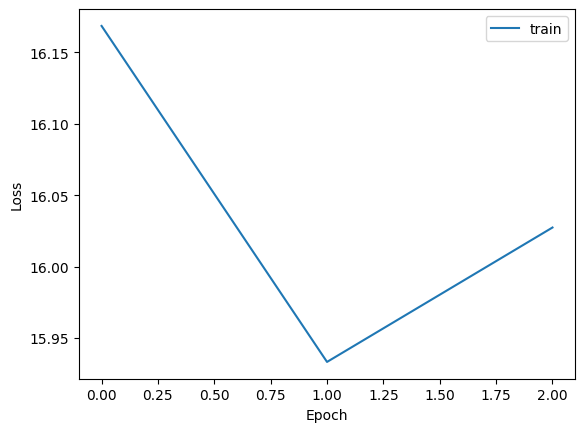

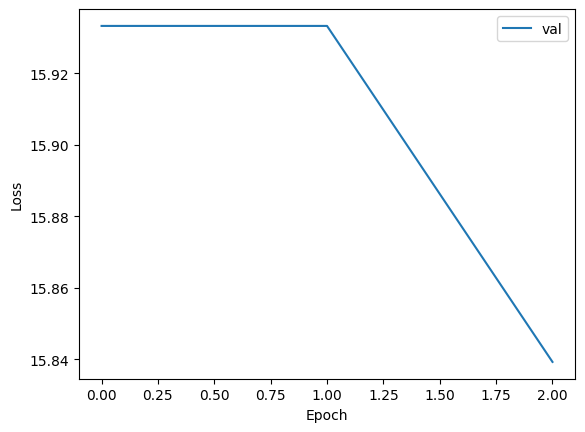

In [66]:
import matplotlib.pyplot as plt
def plot_loss(train_loss,label):
    plt.plot(train_loss, label=label)
#     plt.plot(val_loss, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss(train_losses,'train')
plot_loss(test_losses,'val')

## MODEL 2

In [20]:
import wandb
wandb.login(relogin=True)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [21]:
model_config = {
    'model': 'GRU with Linear Layer',
    'learning_rate': 1e-5,
    'batch_size': 32,
    'optimizer': 'AdamW',
    'loss_function': 'BCELoss'
}
wandb.init(project='assignment-4', entity='nlp-assignments', config=model_config)


epoch,▁▅█
f1_macro,█▁▅
f1_micro,█▁▅
f1_weighted,█▁▄
train_epoch_loss,▁▄█
val_epoch_loss,▁█▅
epoch,2
f1_macro,0.46154
f1_micro,0.85714
f1_weighted,0.79121
train_epoch_loss,16.09116


In [22]:
class Model2(nn.Module):
    def __init__(self, num_classes):
        super(Model2, self).__init__()
        self.embedding = nn.Embedding(50265, 768)
        self.gru = nn.GRU(768, 768, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(768*2, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.embedding(input_ids)
        out, _ = self.gru(out)
        out = out[:, 0, :]
        out = self.fc(out)
        out = torch.sigmoid(out)
        out = torch.round(out)
        return out

In [23]:
model2 = Model2(1)
model2 = model2.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=2e-5)

In [25]:
train_losses,test_losses = train(model2,train_loader,test_loader,criterion,optimizer,1,3)

100%|██████████| 1843/1843 [01:05<00:00, 27.97it/s]


Epoch 1/3, Train Loss: 84.15300617849316


  2%|▏         | 4/229 [00:00<00:06, 35.61it/s]

0.09375
0.125
0.15625
0.15625
0.21875
0.125
0.0625


  5%|▌         | 12/229 [00:00<00:06, 33.30it/s]

0.125
0.125
0.15625
0.15625
0.15625
0.15625
0.09375


  9%|▊         | 20/229 [00:00<00:06, 32.47it/s]

0.15625
0.09375
0.15625
0.15625
0.1875
0.1875
0.15625


 10%|█         | 24/229 [00:00<00:06, 32.07it/s]

0.03125
0.09375
0.28125
0.3125
0.125
0.1875


 12%|█▏        | 28/229 [00:00<00:06, 32.79it/s]

0.28125


 14%|█▍        | 32/229 [00:00<00:05, 33.40it/s]

0.1875
0.15625
0.125
0.3125
0.21875
0.1875
0.125
0.0625


 17%|█▋        | 40/229 [00:01<00:05, 34.99it/s]

0.25
0.0625
0.21875
0.15625
0.09375
0.09375


 19%|█▉        | 44/229 [00:01<00:05, 35.15it/s]

0.15625
0.25


 21%|██        | 48/229 [00:01<00:05, 34.98it/s]

0.1875
0.125
0.125
0.15625
0.0625
0.1875


 23%|██▎       | 52/229 [00:01<00:05, 35.34it/s]

0.03125
0.15625


 24%|██▍       | 56/229 [00:01<00:04, 35.06it/s]

0.125
0.1875
0.28125
0.15625
0.09375
0.25


 26%|██▌       | 60/229 [00:01<00:04, 35.22it/s]

0.125
0.125


 28%|██▊       | 64/229 [00:01<00:04, 34.97it/s]

0.15625
0.15625
0.15625
0.15625
0.15625
0.1875
0.15625


 31%|███▏      | 72/229 [00:02<00:04, 34.26it/s]

0.125
0.21875
0.25
0.25
0.125
0.15625
0.25


 33%|███▎      | 76/229 [00:02<00:04, 34.24it/s]

0.125
0.09375
0.21875
0.0625
0.21875


 35%|███▍      | 80/229 [00:02<00:04, 33.80it/s]

0.125
0.40625


 37%|███▋      | 84/229 [00:02<00:04, 32.41it/s]

0.1875
0.1875
0.15625
0.21875
0.1875


 38%|███▊      | 88/229 [00:02<00:04, 33.34it/s]

0.15625
0.21875


 40%|████      | 92/229 [00:02<00:04, 33.28it/s]

0.21875
0.21875
0.25
0.1875
0.21875
0.03125
0.125


 44%|████▎     | 100/229 [00:02<00:03, 33.89it/s]

0.125
0.09375
0.125
0.125
0.1875
0.125
0.125


 45%|████▌     | 104/229 [00:03<00:03, 33.94it/s]

0.0625
0.1875
0.15625
0.21875
0.21875


 47%|████▋     | 108/229 [00:03<00:03, 33.86it/s]

0.25
0.15625


 49%|████▉     | 112/229 [00:03<00:03, 34.03it/s]

0.21875
0.21875
0.125
0.1875
0.125
0.125

 51%|█████     | 116/229 [00:03<00:03, 34.48it/s]


0.0625
0.25


 52%|█████▏    | 120/229 [00:03<00:03, 34.40it/s]

0.09375
0.15625
0.125
0.125


 54%|█████▍    | 124/229 [00:03<00:03, 34.54it/s]

0.15625
0.125
0.15625


 56%|█████▌    | 128/229 [00:03<00:02, 34.06it/s]

0.09375
0.15625
0.125
0.15625
0.15625
0.1875
0.09375


 58%|█████▊    | 132/229 [00:03<00:02, 34.18it/s]

0.125
0.1875
0.15625
0.125
0.1875

 59%|█████▉    | 136/229 [00:03<00:02, 34.26it/s]


0.21875
0.0625


 61%|██████    | 140/229 [00:04<00:02, 34.15it/s]

0.125
0.125
0.15625
0.09375


 63%|██████▎   | 144/229 [00:04<00:02, 34.36it/s]

0.125
0.25
0.15625
0.1875


 65%|██████▍   | 148/229 [00:04<00:02, 35.55it/s]

0.15625
0.28125
0.3125
0.1875


 66%|██████▋   | 152/229 [00:04<00:02, 35.48it/s]

0.25
0.1875
0.25
0.15625


 68%|██████▊   | 156/229 [00:04<00:02, 35.43it/s]

0.25
0.21875
0.15625
0.1875


 70%|██████▉   | 160/229 [00:04<00:01, 35.59it/s]

0.09375
0.28125
0.125
0.0625


 72%|███████▏  | 164/229 [00:04<00:01, 35.36it/s]

0.09375
0.0625
0.125
0.15625


 73%|███████▎  | 168/229 [00:04<00:01, 35.20it/s]

0.21875
0.15625
0.1875


 75%|███████▌  | 172/229 [00:05<00:01, 34.51it/s]

0.1875
0.125
0.1875
0.125


 77%|███████▋  | 176/229 [00:05<00:01, 34.56it/s]

0.1875
0.15625
0.125


 79%|███████▊  | 180/229 [00:05<00:01, 34.29it/s]

0.15625
0.15625
0.1875
0.15625
0.15625
0.21875
0.15625


 80%|████████  | 184/229 [00:05<00:01, 34.27it/s]

0.125
0.125
0.125
0.09375
0.21875


 82%|████████▏ | 188/229 [00:05<00:01, 34.52it/s]

0.125
0.1875


 84%|████████▍ | 192/229 [00:05<00:01, 33.81it/s]

0.09375
0.15625
0.1875
0.125
0.15625


 86%|████████▌ | 196/229 [00:05<00:00, 33.49it/s]

0.125
0.15625


 87%|████████▋ | 200/229 [00:05<00:00, 33.68it/s]

0.15625
0.0625
0.1875
0.1875
0.1875


 89%|████████▉ | 204/229 [00:05<00:00, 33.63it/s]

0.1875
0.125


 91%|█████████ | 208/229 [00:06<00:00, 33.80it/s]

0.125
0.1875
0.0625
0.09375
0.21875


 93%|█████████▎| 212/229 [00:06<00:00, 34.30it/s]

0.21875
0.15625
0.1875


 94%|█████████▍| 216/229 [00:06<00:00, 34.40it/s]

0.21875
0.25
0.21875
0.34375
0.15625
0.1875
0.125


 96%|█████████▌| 220/229 [00:06<00:00, 33.86it/s]

0.125
0.25
0.15625
0.125


 98%|█████████▊| 224/229 [00:06<00:00, 33.77it/s]

0.1875
0.15625
0.09375


100%|██████████| 229/229 [00:06<00:00, 34.17it/s]


0.25
0.09375
0.14285714285714285
Epoch 1/3, Test Loss: 83.76676544455982,F1 micro:0.14285714285714285, F1 macro:0.125,F1 weighted:0.03571428571428571


100%|██████████| 1843/1843 [01:05<00:00, 28.03it/s]


Epoch 2/3, Train Loss: 84.15796256104178


  2%|▏         | 4/229 [00:00<00:06, 35.00it/s]

0.125
0.1875
0.15625
0.1875
0.1875
0.28125
0.125
0.21875

  5%|▌         | 12/229 [00:00<00:06, 35.29it/s]


0.125
0.28125
0.28125
0.15625
0.15625
0.0625
0.1875


  9%|▊         | 20/229 [00:00<00:05, 35.19it/s]

0.15625
0.15625
0.125
0.09375
0.15625
0.03125
0.21875


 12%|█▏        | 28/229 [00:00<00:05, 35.19it/s]

0.125
0.25
0.25
0.21875
0.1875
0.1875
0.125
0.15625


 16%|█▌        | 36/229 [00:01<00:05, 34.41it/s]

0.1875
0.1875
0.21875
0.28125
0.25
0.21875
0.15625


 17%|█▋        | 40/229 [00:01<00:05, 34.08it/s]

0.15625
0.125
0.15625
0.1875
0.125
0.25


 19%|█▉        | 44/229 [00:01<00:05, 34.08it/s]

0.1875


 21%|██        | 48/229 [00:01<00:05, 34.24it/s]

0.0625
0.0625
0.15625
0.09375
0.09375
0.125
0.125


 23%|██▎       | 52/229 [00:01<00:05, 34.63it/s]

0.21875


 24%|██▍       | 56/229 [00:01<00:04, 34.70it/s]

0.15625
0.15625
0.25
0.09375
0.28125
0.3125
0.0625


 28%|██▊       | 64/229 [00:01<00:04, 34.77it/s]

0.125
0.0625
0.21875
0.09375
0.125
0.1875
0.25
0.21875


 31%|███▏      | 72/229 [00:02<00:04, 35.27it/s]

0.15625
0.28125
0.15625
0.21875
0.125
0.0625
0.28125
0.0625


 35%|███▍      | 80/229 [00:02<00:04, 34.66it/s]

0.21875
0.28125
0.09375
0.15625
0.125
0.25
0.125


 38%|███▊      | 88/229 [00:02<00:04, 33.85it/s]

0.125
0.125
0.09375
0.125
0.28125
0.21875
0.15625


 42%|████▏     | 96/229 [00:02<00:03, 34.21it/s]

0.0625
0.125
0.0625
0.1875
0.0625
0.21875
0.15625
0.09375


 45%|████▌     | 104/229 [00:03<00:03, 34.52it/s]

0.25
0.21875
0.125
0.25
0.28125
0.125
0.09375
0.25


 49%|████▉     | 112/229 [00:03<00:03, 34.03it/s]

0.3125
0.0625
0.09375
0.15625
0.15625
0.125
0.09375


 51%|█████     | 116/229 [00:03<00:03, 34.02it/s]

0.21875
0.09375
0.09375
0.21875
0.28125
0.21875
0.25
0.21875


 54%|█████▍    | 124/229 [00:03<00:03, 34.00it/s]

0.09375
0.125
0.0625
0.09375
0.21875
0.125
0.1875


 58%|█████▊    | 132/229 [00:03<00:02, 34.10it/s]

0.21875
0.125
0.1875
0.15625
0.03125
0.15625
0.0625
0.125


 61%|██████    | 140/229 [00:04<00:02, 33.93it/s]

0.0625
0.125
0.1875
0.1875
0.1875
0.125
0.125


 65%|██████▍   | 148/229 [00:04<00:02, 34.31it/s]

0.125
0.15625
0.125
0.0625
0.15625
0.0625
0.3125


 68%|██████▊   | 156/229 [00:04<00:02, 33.34it/s]

0.15625
0.21875
0.25
0.21875
0.09375
0.15625
0.09375


 70%|██████▉   | 160/229 [00:04<00:02, 32.95it/s]

0.09375
0.125
0.15625
0.15625
0.15625
0.0625
0.125


 73%|███████▎  | 168/229 [00:04<00:01, 34.35it/s]

0.25
0.15625
0.125
0.1875
0.125
0.125
0.15625
0.125


 77%|███████▋  | 176/229 [00:05<00:01, 34.69it/s]

0.25
0.15625
0.125
0.15625
0.15625
0.09375
0.21875


 80%|████████  | 184/229 [00:05<00:01, 34.83it/s]

0.125
0.09375
0.09375
0.1875
0.09375
0.15625
0.125


 84%|████████▍ | 192/229 [00:05<00:01, 33.57it/s]

0.25
0.25
0.3125
0.09375
0.09375
0.28125
0.0625


 86%|████████▌ | 196/229 [00:05<00:00, 33.31it/s]

0.15625
0.15625
0.09375
0.1875
0.15625
0.125
0.28125


 89%|████████▉ | 204/229 [00:05<00:00, 33.45it/s]

0.15625
0.25
0.125
0.21875
0.25
0.09375
0.09375


 93%|█████████▎| 212/229 [00:06<00:00, 33.51it/s]

0.1875
0.0625
0.125
0.15625
0.03125
0.125
0.21875
0.1875


 96%|█████████▌| 220/229 [00:06<00:00, 34.49it/s]

0.125
0.09375
0.25
0.25
0.25
0.21875
0.15625
0.15625


100%|██████████| 229/229 [00:06<00:00, 34.29it/s]


0.09375
0.1875
0.15625
0.34375
0.125
0.1875
0.25
Epoch 2/3, Test Loss: 83.76091703056768,F1 micro:0.25, F1 macro:0.2,F1 weighted:0.1


100%|██████████| 1843/1843 [01:05<00:00, 27.99it/s]


Epoch 3/3, Train Loss: 84.15796256104178


  2%|▏         | 4/229 [00:00<00:06, 34.74it/s]

0.1875
0.125
0.09375
0.21875
0.1875
0.1875
0.21875


  5%|▌         | 12/229 [00:00<00:06, 34.27it/s]

0.21875
0.15625
0.09375
0.1875
0.125
0.125
0.15625


  9%|▊         | 20/229 [00:00<00:05, 34.96it/s]

0.34375
0.28125
0.125
0.15625
0.15625
0.0625
0.125
0.3125


 12%|█▏        | 28/229 [00:00<00:05, 34.66it/s]

0.125
0.15625
0.15625
0.09375
0.28125
0.09375
0.15625


 14%|█▍        | 32/229 [00:00<00:05, 33.97it/s]

0.0625
0.1875
0.15625
0.09375
0.21875
0.09375


 16%|█▌        | 36/229 [00:01<00:05, 33.78it/s]

0.15625


 17%|█▋        | 40/229 [00:01<00:05, 33.79it/s]

0.09375
0.09375
0.125
0.15625
0.09375
0.125
0.28125


 21%|██        | 48/229 [00:01<00:05, 34.35it/s]

0.28125
0.15625
0.15625
0.1875
0.21875
0.1875
0.125
0.21875


 24%|██▍       | 56/229 [00:01<00:05, 34.40it/s]

0.1875
0.15625
0.15625
0.09375
0.125
0.09375
0.0625
0.15625


 28%|██▊       | 64/229 [00:01<00:04, 35.59it/s]

0.3125
0.375
0.09375
0.125
0.15625
0.15625
0.125
0.125


 31%|███▏      | 72/229 [00:02<00:04, 34.77it/s]

0.15625
0.15625
0.09375
0.21875
0.21875
0.1875
0.1875
0.0625


 35%|███▍      | 80/229 [00:02<00:04, 35.62it/s]

0.15625
0.15625
0.1875
0.3125
0.1875
0.1875
0.125
0.03125


 38%|███▊      | 88/229 [00:02<00:03, 35.42it/s]

0.125
0.125
0.125
0.1875
0.09375
0.1875
0.21875
0.09375


 42%|████▏     | 96/229 [00:02<00:03, 35.39it/s]

0.15625
0.15625
0.09375
0.21875
0.1875
0.15625
0.21875


 44%|████▎     | 100/229 [00:02<00:03, 34.88it/s]

0.09375
0.25
0.25
0.125
0.25
0.1875


 45%|████▌     | 104/229 [00:02<00:03, 35.25it/s]

0.09375
0.1875


 49%|████▉     | 112/229 [00:03<00:03, 35.58it/s]

0.1875
0.125
0.1875
0.15625
0.25
0.125
0.09375
0.09375


 51%|█████     | 116/229 [00:03<00:03, 35.11it/s]

0.21875
0.15625
0.0625
0.3125
0.1875


 52%|█████▏    | 120/229 [00:03<00:03, 34.65it/s]

0.125
0.15625


 54%|█████▍    | 124/229 [00:03<00:03, 34.45it/s]

0.21875
0.1875
0.125
0.15625
0.3125


 56%|█████▌    | 128/229 [00:03<00:02, 34.72it/s]

0.1875
0.125
0.03125


 58%|█████▊    | 132/229 [00:03<00:02, 35.22it/s]

0.15625
0.1875
0.25
0.21875
0.03125


 59%|█████▉    | 136/229 [00:03<00:02, 34.98it/s]

0.15625
0.1875
0.1875


 61%|██████    | 140/229 [00:04<00:02, 34.74it/s]

0.15625
0.25
0.1875
0.1875


 63%|██████▎   | 144/229 [00:04<00:02, 34.73it/s]

0.09375
0.25
0.28125
0.03125


 65%|██████▍   | 148/229 [00:04<00:02, 35.03it/s]

0.125
0.1875
0.15625


 66%|██████▋   | 152/229 [00:04<00:02, 34.82it/s]

0.25
0.1875
0.03125
0.1875
0.125
0.125
0.1875
0.1875


 70%|██████▉   | 160/229 [00:04<00:01, 35.13it/s]

0.25
0.1875
0.09375
0.125


 72%|███████▏  | 164/229 [00:04<00:01, 35.34it/s]

0.25
0.0625
0.1875
0.15625


 73%|███████▎  | 168/229 [00:04<00:01, 35.24it/s]

0.125
0.21875
0.21875
0.09375
0.15625
0.15625
0.15625


 75%|███████▌  | 172/229 [00:04<00:01, 34.23it/s]

0.125
0.1875
0.1875
0.125


 77%|███████▋  | 176/229 [00:05<00:01, 34.25it/s]

0.125
0.125
0.1875
0.15625


 79%|███████▊  | 180/229 [00:05<00:01, 34.83it/s]

0.03125
0.1875
0.09375


 80%|████████  | 184/229 [00:05<00:01, 33.82it/s]

0.1875
0.21875
0.15625
0.1875


 82%|████████▏ | 188/229 [00:05<00:01, 34.35it/s]

0.09375
0.1875
0.125


 84%|████████▍ | 192/229 [00:05<00:01, 34.27it/s]

0.21875
0.15625
0.25
0.28125
0.21875


 86%|████████▌ | 196/229 [00:05<00:00, 34.64it/s]

0.15625
0.15625
0.125


 87%|████████▋ | 200/229 [00:05<00:00, 34.41it/s]

0.03125
0.21875
0.09375
0.1875


 89%|████████▉ | 204/229 [00:05<00:00, 34.52it/s]

0.125
0.0625
0.28125


 91%|█████████ | 208/229 [00:05<00:00, 34.59it/s]

0.09375
0.15625
0.125
0.15625


 93%|█████████▎| 212/229 [00:06<00:00, 34.76it/s]

0.21875
0.15625
0.125
0.25
0.09375
0.15625
0.09375
0.1875

 94%|█████████▍| 216/229 [00:06<00:00, 34.40it/s]


0.25
0.15625
0.15625


 96%|█████████▌| 220/229 [00:06<00:00, 34.24it/s]

0.125
0.09375
0.125


 98%|█████████▊| 224/229 [00:06<00:00, 34.33it/s]

0.25
0.125
0.125
0.125


100%|██████████| 229/229 [00:06<00:00, 34.69it/s]

0.15625
0.21875
0.14285714285714285
Epoch 3/3, Test Loss: 83.76676544455982,F1 micro:0.14285714285714285, F1 macro:0.125,F1 weighted:0.03571428571428571


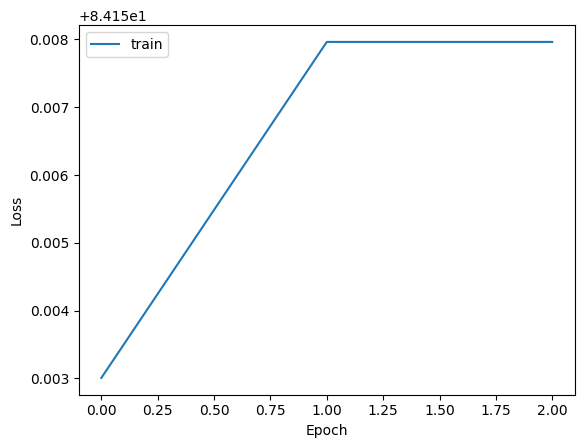

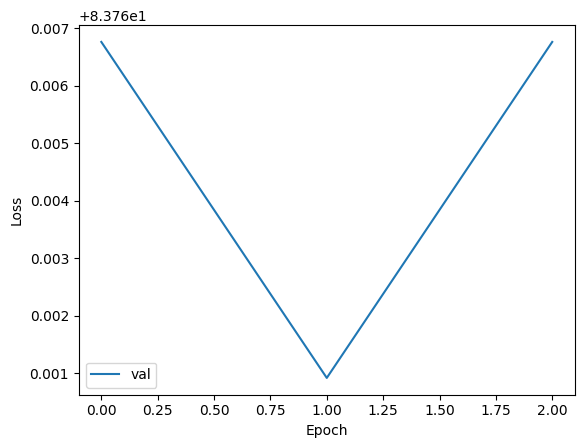

In [26]:
import matplotlib.pyplot as plt
def plot_loss(train_loss,label):
    plt.plot(train_loss, label=label)
#     plt.plot(val_loss, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss(train_losses,'train')
plot_loss(test_losses,'val')